### Multi-Agent Math Solver with LangGraph

In [37]:
# Import necessary libraries
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from typing import TypedDict

In [32]:
# Define the state
class MathState(TypedDict):
    query: str
    level: str
    response: str

#### Define Agents

In [33]:
# Level 1 Agent – School Students
def school_agent(state: MathState) -> MathState:
    q = state["query"]
    response = f"[School Agent] Solving basic math for: {q}\n"
    if "12 x 8" in q or "12 × 8" in q:
        response += "12 × 8 = 96. Think of it as 12 groups of 8 apples = 96 apples."
    else:
        response += "This looks like a simple arithmetic problem. Answer = (demo only)."
    return {"query": q, "level": "school", "response": response}

In [34]:
# Level 2 Agent – College Students
def college_agent(state: MathState) -> MathState:
    q = state["query"]
    response = f"[College Agent] Solving intermediate math for: {q}\n"
    if "derivative" in q:
        response += "d/dx(3x² + 5x) = 6x + 5"
    else:
        response += "This looks like algebra/trigonometry/calculus basics. Answer = (demo only)."
    return {"query": q, "level": "college", "response": response}

In [35]:
# Level 3 Agent – University Students
def university_agent(state: MathState) -> MathState:
    q = state["query"]
    response = f"[University Agent] Solving advanced math for: {q}\n"
    if "differential equation" in q:
        response += ("Solve dy/dx + y = e^x:\n"
                     "Integrating factor μ(x) = e^x\n"
                     "d/dx(ye^x) = e^(2x)\n"
                     "∫ d/dx(ye^x) dx = ∫ e^(2x) dx\n"
                     "ye^x = (1/2)e^(2x) + C\n"
                     "y = (1/2)e^x + Ce^(-x)")
    else:
        response += "This looks like advanced linear algebra/calculus/statistics. Answer = (demo only)."
    return {"query": q, "level": "university", "response": response}

In [36]:

# Controller Agent – Chooses the right agent
def controller(state: MathState) -> str:
    q = state["query"].lower()
    if any(keyword in q for keyword in ["add", "multiply", "basic", "simple", "12", "apples"]):
        return "school"
    elif "derivative" in q or "integral" in q:
        return "college"
    elif "differential equation" in q or "matrix" in q:
        return "university"
    else:
        return "school"  

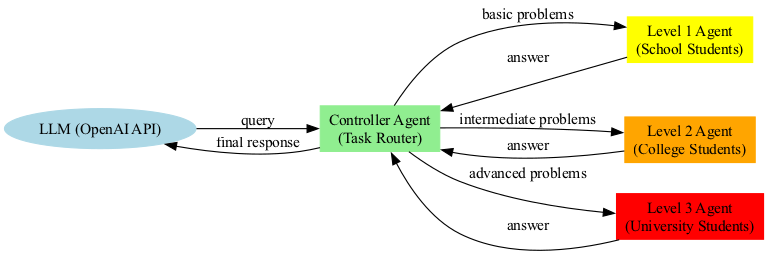

In [19]:
from graphviz import Digraph
from IPython.display import Image, display

# Create directed graph
dot = Digraph(comment="Multi-Agent Workflow", format="png")
dot.attr(rankdir='LR', size='8,5')  # Left-to-right

# Main LLM Node
dot.node("LLM", "LLM (OpenAI API)", shape="ellipse", style="filled", color="lightblue")

# Controller Agent
dot.node("Controller", "Controller Agent\n(Task Router)", shape="box", style="filled", color="lightgreen")

# Level Agents
dot.node("L1", "Level 1 Agent\n(School Students)", shape="box", style="filled", color="yellow")
dot.node("L2", "Level 2 Agent\n(College Students)", shape="box", style="filled", color="orange")
dot.node("L3", "Level 3 Agent\n(University Students)", shape="box", style="filled", color="red")

# Edges
dot.edge("LLM", "Controller", label="query")
dot.edge("Controller", "L1", label="basic problems")
dot.edge("Controller", "L2", label="intermediate problems")
dot.edge("Controller", "L3", label="advanced problems")
dot.edge("L1", "Controller", label="answer")
dot.edge("L2", "Controller", label="answer")
dot.edge("L3", "Controller", label="answer")
dot.edge("Controller", "LLM", label="final response")

# Save and render
output_path = "multi_agent_workflow"
dot.render(output_path, cleanup=True)

# Display inside notebook
display(Image(filename=output_path + ".png"))


In [38]:
# Build LangGraph

workflow = StateGraph(MathState)

workflow.add_node("school", school_agent)
workflow.add_node("college", college_agent)
workflow.add_node("university", university_agent)

workflow.set_conditional_entry_point(controller)

workflow.add_edge("school", END)
workflow.add_edge("college", END)
workflow.add_edge("university", END)

app = workflow.compile()

In [39]:
# Test Cases

test_cases = [
    {"query": "What is 12 × 8?"},
    {"query": "Find the derivative of 3x² + 5x"},
    {"query": "Solve the differential equation dy/dx + y = e^x"},
]

for i, case in enumerate(test_cases, 1):
    result = app.invoke(case)
    print(f"\nTest Case {i}: {case['query']}")
    print("Output:", result["response"])



Test Case 1: What is 12 × 8?
Output: [School Agent] Solving basic math for: What is 12 × 8?
12 × 8 = 96. Think of it as 12 groups of 8 apples = 96 apples.

Test Case 2: Find the derivative of 3x² + 5x
Output: [College Agent] Solving intermediate math for: Find the derivative of 3x² + 5x
d/dx(3x² + 5x) = 6x + 5

Test Case 3: Solve the differential equation dy/dx + y = e^x
Output: [University Agent] Solving advanced math for: Solve the differential equation dy/dx + y = e^x
Solve dy/dx + y = e^x:
Integrating factor μ(x) = e^x
d/dx(ye^x) = e^(2x)
∫ d/dx(ye^x) dx = ∫ e^(2x) dx
ye^x = (1/2)e^(2x) + C
y = (1/2)e^x + Ce^(-x)
